# Install Environment

In [ ]:
# !pip install datasets
# !pip install transformers[torch]

import os
import pandas as pd
import torch
import transformers as tr
from datasets import Dataset, load_metric
import numpy as np
from transformers import Trainer
from sklearn.metrics import classification_report, accuracy_score

# Data Importing

## Clean Data

In [2]:
# GonzaloA data
gonzaloa_train = pd.read_csv(
    "https://github.com/AnasElbattra/Hugging-face/raw/main/FAKE-REAL/DATA/GonzaloA_fake_news/train%20Data.csv"
)  # 24352 row
gonzaloa_train = gonzaloa_train[["text", "label"]]
# gonzaloa_train['label'].replace({0: 'fake', 1: 'real'}, inplace=True)


gonzaloa_test = pd.read_csv(
    "https://github.com/AnasElbattra/Hugging-face/raw/main/FAKE-REAL/DATA/GonzaloA_fake_news/test%20Data.csv"
)  # 16240 row
gonzaloa_test = gonzaloa_test[["text", "label"]]
# gonzaloa_test['label'].replace({0: 'fake', 1: 'real'}, inplace=True)


# pushpdeepfake_news_combined
pushpdeepfake_train = pd.read_csv(
    "https://github.com/AnasElbattra/Hugging-face/raw/main/FAKE-REAL/DATA/pushpdeepfake_news_combined/train.csv"
)  # 34916 row
pushpdeepfake_train = pushpdeepfake_train[["text", "label"]]
# clean_2_train['label'].replace({0: 'fake', 1: 'real'}, inplace=True)


pushpdeepfake_test = pd.read_csv(
    "https://github.com/AnasElbattra/Hugging-face/raw/main/FAKE-REAL/DATA/pushpdeepfake_news_combined/test.csv"
)  # 10003 row
pushpdeepfake_test = pushpdeepfake_test[["text", "label"]]
# pushpdeepfake_test['label'].replace({0: 'fake', 1: 'real'}, inplace=True)

## Trash Data

In [3]:
# kaggle_datafake
kaggle_train = pd.read_csv(
    "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/kaggle_datafake/kaggle_datafake_train.csv"
)  # 24000 row
kaggle_train = kaggle_train[["text", "label"]]

kaggle_test = pd.read_csv(
    "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/kaggle_datafake/kaggle_datafake_test.csv"
)  # 208003 row
kaggle_test = kaggle_test[["text", "label"]]

# news_articles
news_articles = pd.read_csv(
    "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/news_articles.csv"
)  # 2100 row
news_articles = news_articles[["text", "label"]]
news_articles["label"] = news_articles["label"].str.lower()

## New Data

In [4]:
# mrm8488-fake-news
mrm8488_fake_news = pd.read_csv(
    "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/mrm8488-fake-news/fake_news.csv"
)  # 44919 row


# ErfanMoosaviMonzzah
Erfan_train = pd.read_csv(
    "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/ErfanMoosaviMonazzah/train.csv"
)  # 20011 row
Erfan_train = Erfan_train[["text", "label"]]

Erfan_test = pd.read_csv(
    "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/ErfanMoosaviMonazzah/test.csv"
)  # 24277 row
Erfan_test = Erfan_test[["text", "label"]]

## Data Combination

In [10]:
# combine gonzaloa_train, pushpdeepfake_train
# training_data = pd.concat([gonzaloa_train, pushpdeepfake_train], ignore_index=True)
training_data = Erfan_train

dataset = Dataset.from_pandas(training_data)
dataset = dataset.train_test_split(test_size=0.2)
# dataset["train"]["label"]

# Fine Tuning


In [11]:
def to_tokens(tokenizer, label_map):
    def apply(x):
        target_labels = [label_map[y] for y in x["label"]]
        token_res = tokenizer(
            x["text"],
            text_target=target_labels,
            return_tensors="pt",
            truncation=True,
            padding=True,
        )
        return token_res

    return apply

In [12]:
tokenizer = tr.AutoTokenizer.from_pretrained("t5-small")

In [13]:
label_lookup = {0: "fake", 1: "real"}
to_tokens = to_tokens(tokenizer, label_lookup)
tokenized_dataset = dataset.map(
    to_tokens, batched=True, remove_columns=["text", "label"]
)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [14]:
local_training_root = "./"
checkpoint_name = "test-trainer"
local_checkpoint_path = os.path.join(local_training_root, checkpoint_name)
training_args = tr.TrainingArguments(
    local_checkpoint_path,
    num_train_epochs=1,  # default number of epochs to train is 3
    per_device_train_batch_size=16,
    optim="adamw_torch",
    report_to=["tensorboard"],
)

In [15]:
t5_model = tr.AutoModelForSeq2SeqLM.from_pretrained("t5-small")

In [16]:
metric = load_metric("accuracy")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = [
        tokenizer.decode(p, skip_special_tokens=True)
        for p in predictions.argmax(dim=-1)
    ]
    labels = [label_lookup[l] for l in labels]

    return metric.compute(predictions=predictions, references=labels)

<ipython-input-16-1bce426d05f6>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [17]:
trainer = Trainer(
    model=t5_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
)
trainer.train()

Step,Training Loss
500,0.537800
1000,0.013300


TrainOutput(global_step=1000, training_loss=0.275549955368042, metrics={'train_runtime': 490.7507, 'train_samples_per_second': 32.603, 'train_steps_per_second': 2.038, 'total_flos': 2165468823552000.0, 'train_loss': 0.275549955368042, 'epoch': 1.0})

In [18]:
# trainer.evaluate()
trainer.save_model()
trainer.save_state()
checkpoint_name = "test-trainer-deepspeed"
final_model_path = f"./llm04_fine_tuning/{checkpoint_name}"

trainer.save_model(output_dir=final_model_path)

fine_tuned_model = tr.AutoModelForSeq2SeqLM.from_pretrained(final_model_path)

# Evaluation

## Data Cleaning and sampling

In [27]:
# Take 100 samples from each dataset
# gonzaloa_train
gonzaloa_train = gonzaloa_train.groupby("label", group_keys=False).apply(
    lambda x: x.sample(min(len(x), 50))
)
gonzaloa_train = gonzaloa_train.sample(frac=1, random_state=42)
gonzaloa_train.dropna(subset=["text"], inplace=True)
gonzaloa_train["label"].replace({0: "fake", 1: "real"}, inplace=True)

# gonzaloa_test
gonzaloa_test = gonzaloa_test.groupby("label", group_keys=False).apply(
    lambda x: x.sample(min(len(x), 50))
)
gonzaloa_test = gonzaloa_test.sample(frac=1, random_state=42)
gonzaloa_test.dropna(subset=["text"], inplace=True)
gonzaloa_test["label"].replace({0: "fake", 1: "real"}, inplace=True)

# pushpdeepfake_train
pushpdeepfake_train = pushpdeepfake_train.groupby("label", group_keys=False).apply(
    lambda x: x.sample(min(len(x), 50))
)
pushpdeepfake_train = pushpdeepfake_train.sample(frac=1, random_state=42)
pushpdeepfake_train.dropna(subset=["text"], inplace=True)
pushpdeepfake_train["label"].replace({0: "fake", 1: "real"}, inplace=True)

# pushpdeepfake_test
pushpdeepfake_test = pushpdeepfake_test.groupby("label", group_keys=False).apply(
    lambda x: x.sample(min(len(x), 50))
)
pushpdeepfake_test = pushpdeepfake_test.sample(frac=1, random_state=42)
pushpdeepfake_test.dropna(subset=["text"], inplace=True)
pushpdeepfake_test["label"].replace({0: "fake", 1: "real"}, inplace=True)

# kaggle_train
kaggle_train = kaggle_train.groupby("label", group_keys=False).apply(
    lambda x: x.sample(min(len(x), 50))
)
kaggle_train = kaggle_train.sample(frac=1, random_state=42)
kaggle_train.dropna(subset=["text"], inplace=True)
kaggle_train["label"].replace({0: "fake", 1: "real"}, inplace=True)

# kaggle_test
kaggle_test = kaggle_test.groupby("label", group_keys=False).apply(
    lambda x: x.sample(min(len(x), 50))
)
kaggle_test = kaggle_test.sample(frac=1, random_state=42)
kaggle_test.dropna(subset=["text"], inplace=True)
kaggle_test["label"].replace({0: "fake", 1: "real"}, inplace=True)

# news_articles
news_articles = news_articles.groupby("label", group_keys=False).apply(
    lambda x: x.sample(min(len(x), 50))
)
news_articles = news_articles.sample(frac=1, random_state=42)
news_articles.dropna(subset=["text"], inplace=True)
news_articles["label"].replace({0: "fake", 1: "real"}, inplace=True)

# mrm8488_fake_news
mrm8488_fake_news = mrm8488_fake_news.groupby("label", group_keys=False).apply(
    lambda x: x.sample(min(len(x), 50))
)
mrm8488_fake_news = mrm8488_fake_news.sample(frac=1, random_state=42)
mrm8488_fake_news.dropna(subset=["text"], inplace=True)
mrm8488_fake_news["label"].replace({0: "fake", 1: "real"}, inplace=True)

# Erfan_test
Erfan_test = Erfan_test.groupby("label", group_keys=False).apply(
    lambda x: x.sample(min(len(x), 50))
)
Erfan_test = Erfan_test.sample(frac=1, random_state=42)
Erfan_test.dropna(subset=["text"], inplace=True)
Erfan_test["label"].replace({0: "fake", 1: "real"}, inplace=True)

In [20]:
def evaluate_data(df):
    # Initialize an empty list to store the predictions
    predictions = []

    # Iterate through each row in the DataFrame
    for index, row in df.iterrows():
        text = row["text"]
        news_report = [text]  # Create a list with the text from the DataFrame

        # Tokenize and generate predictions
        inputs = tokenizer(
            news_report, return_tensors="pt", truncation=True, padding=True
        )
        pred = fine_tuned_model.generate(
            input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"]
        )

        # Decode the predictions and store them in the predictions list
        classification = tokenizer.batch_decode(pred, skip_special_tokens=True)[0]
        predictions.append(classification)

    # Add the predictions to the DataFrame as a new column
    df["predictions"] = predictions

    classification_rep = classification_report(df["label"], df["predictions"])
    print("Classification Report:")
    print(classification_rep)

    accuracy = accuracy_score(df["label"], df["predictions"])

    return accuracy

## Evaluation on the samples

In [29]:
gonzaloa_train_accuracy = evaluate_data(gonzaloa_train)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.94      1.00      0.97        50
        real       1.00      0.94      0.97        50

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



In [30]:
gonzaloa_test_accuracy = evaluate_data(gonzaloa_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.98      0.96      0.97        50
        real       0.96      0.98      0.97        50

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



In [31]:
pushpdeepfake_train_accuracy = evaluate_data(pushpdeepfake_train)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00        50
        real       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [32]:
pushpdeepfake_test_accuracy = evaluate_data(pushpdeepfake_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.96      0.98      0.97        50
        real       0.98      0.96      0.97        50

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



In [33]:
kaggle_train_accuracy = evaluate_data(kaggle_train)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        True       0.00      0.00      0.00         0
        fake       0.09      0.02      0.03        50
        real       0.44      0.78      0.57        50

    accuracy                           0.40       100
   macro avg       0.18      0.27      0.20       100
weighted avg       0.27      0.40      0.30       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
kaggle_test_accuracy = evaluate_data(kaggle_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.13      0.04      0.06        50
        real       0.44      0.74      0.55        50

    accuracy                           0.39       100
   macro avg       0.28      0.39      0.30       100
weighted avg       0.28      0.39      0.30       100



In [35]:
news_articles_accuracy = evaluate_data(news_articles)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.56      0.80      0.66        50
   fake fake       0.00      0.00      0.00         0
        real       0.64      0.33      0.44        48

    accuracy                           0.57        98
   macro avg       0.40      0.38      0.36        98
weighted avg       0.60      0.57      0.55        98



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
mrm8488_fake_news_accuracy = evaluate_data(mrm8488_fake_news)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00        50
        real       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [37]:
erfan_test_accuracy = evaluate_data(Erfan_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00        50
        real       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



## Bar Chart

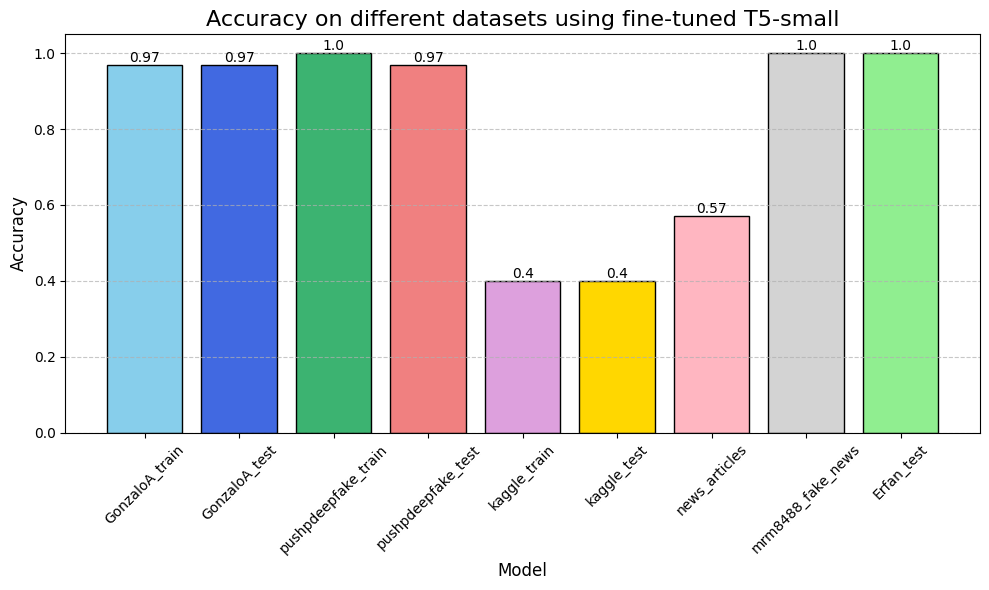

In [40]:
import matplotlib.pyplot as plt

# Model labels
models = [
    "GonzaloA_train",
    "GonzaloA_test",
    "pushpdeepfake_train",
    "pushpdeepfake_test",
    "kaggle_train",
    "kaggle_test",
    "news_articles",
    "mrm8488_fake_news",
    "Erfan_test",
]

# Accuracy values
accuracies = [
    gonzaloa_train_accuracy,
    gonzaloa_test_accuracy,
    pushpdeepfake_train_accuracy,
    pushpdeepfake_test_accuracy,
    kaggle_train_accuracy,
    kaggle_train_accuracy,
    news_articles_accuracy,
    mrm8488_fake_news_accuracy,
    erfan_test_accuracy,
]

# Create a color list to distinguish between 'summ' and non-summ models
colors = [
    "skyblue",
    "royalblue",
    "mediumseagreen",
    "lightcoral",
    "plum",
    "gold",
    "lightpink",
    "lightgrey",
    "lightgreen",
]

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=colors, edgecolor="black")

# Adding value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        round(yval, 2),
        va="bottom",
        ha="center",
    )

plt.title("Accuracy on different datasets using fine-tuned T5-small", fontsize=16)
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.xticks(rotation=45, fontsize=10)

# Adding a grid
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()